In [1]:
library(Seurat)
library(Signac)
library(CellChat)
library(patchwork)
library(argparse)
source("/tscc/projects/ps-epigen/users/kdang/eye_final/source_FunFig.R")
library(dplyr)                                                               
library(devtools)
library(hdf5r)
source("/tscc/projects/ps-epigen/bpToolbox/utils.R")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Loading required package: usethis

Warning message:
“package ‘hdf5r’ was built under R version 4.4.2”


In [2]:
setwd("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/SCT/250322_three_libs_run_noharm")

In [3]:
sobj <- readRDS("250322_3_libs_w_demux_meta_sct_batch.RDS")

In [4]:
sobj

An object of class Seurat 
57618 features across 34422 samples within 2 assays 
Active assay: SCT (24080 features, 5000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap.hrm.rna

In [5]:
unique(colnames(sobj@meta.data))

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "INT_ID"             "BARCODE"            "NUM.SNPS"          
 [7] "NUM.READS"          "DROPLET.TYPE"       "BEST.GUESS"        
[10] "BEST.LLK"           "NEXT.GUESS"         "NEXT.LLK"          
[13] "DIFF.LLK.BEST.NEXT" "BEST.POSTERIOR"     "SNG.POSTERIOR"     
[16] "SNG.BEST.GUESS"     "SNG.BEST.LLK"       "SNG.NEXT.GUESS"    
[19] "SNG.NEXT.LLK"       "SNG.ONLY.POSTERIOR" "DBL.BEST.GUESS"    
[22] "DBL.BEST.LLK"       "DIFF.LLK.SNG.DBL"   "percent.mt"        
[25] "nCount_SCT"         "nFeature_SCT"       "SCT_snn_res.1"     
[28] "seurat_clusters"

In [6]:
unique(sobj$orig.ident)

[1] "JB_1495_Organoid"     "JB_1496_Organoid"     "JB_1466_1_2_Organoid"

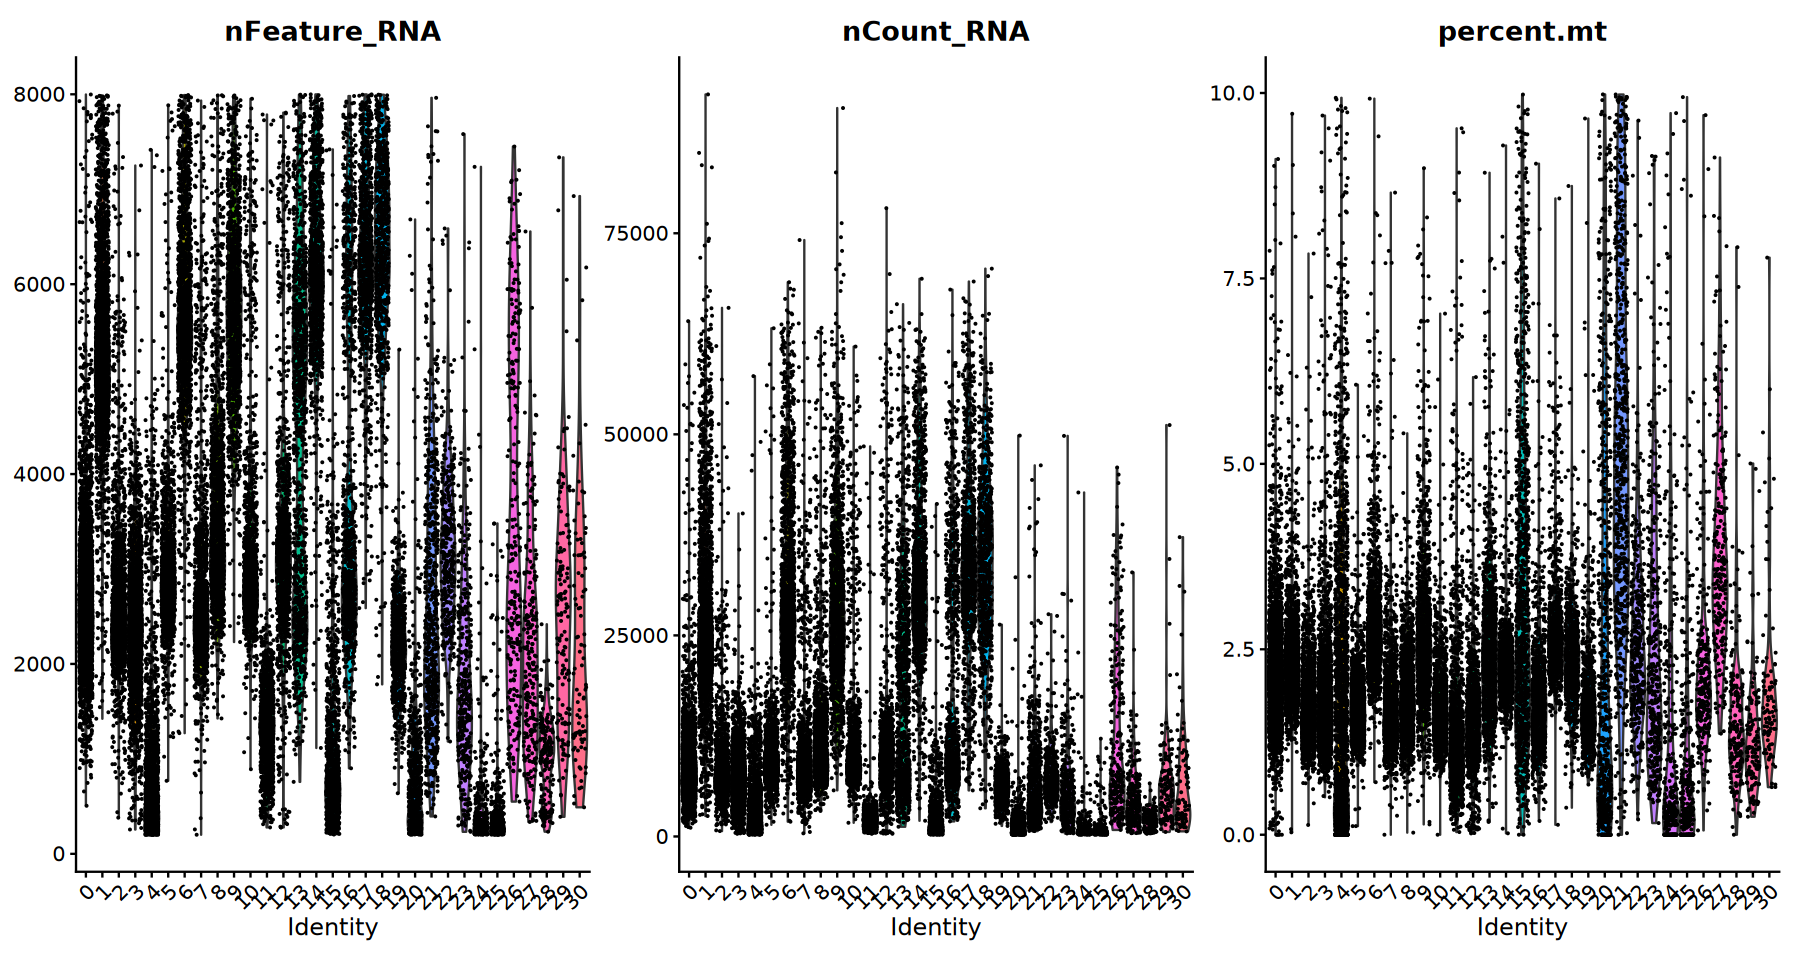

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
# Visualize QC metrics as a violin plot
VlnPlot(sobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [8]:
DefaultAssay(sobj) <- 'RNA'


In [9]:
unique(sobj$BEST.GUESS)

[1] "0_0_1_ZBC1,0_0_1_ZBC1,0.00" "0_0_4_ZBl1,0_0_4_ZBl1,0.00"
 [3] "0_0_2_ZBC2,0_0_2_ZBC2,0.00" "0_0_3_ZBC3,0_0_3_ZBC3,0.00"
 [5] "0_0_5_ZBl2,0_0_5_ZBl2,0.00" "0_0_1_ZBC1,0_0_6_ZBl3,0.50"
 [7] "0_0_6_ZBl3,0_0_6_ZBl3,0.00" "0_0_1_ZBC1,0_0_2_ZBC2,0.50"
 [9] NA                           "0_0_1_ZBC1,0_0_3_ZBC3,0.50"
[11] "0_0_3_ZBC3,0_0_5_ZBl2,0.50"

In [11]:
library(harmony)

Loading required package: Rcpp



In [13]:
sum(is.na(sobj$orig.ident))
sum(is.na(sobj$BEST.GUESS))


[1] 0

[1] 33212

In [14]:
sobj$BEST.GUESS[is.na(sobj$BEST.GUESS)] <- "unknown"
sobj$BEST.GUESS <- as.factor(sobj$BEST.GUESS)  # Ensure it's a factor


In [15]:
unique(sobj$BEST.GUESS)

[1] 0_0_1_ZBC1,0_0_1_ZBC1,0.00 0_0_4_ZBl1,0_0_4_ZBl1,0.00
 [3] 0_0_2_ZBC2,0_0_2_ZBC2,0.00 0_0_3_ZBC3,0_0_3_ZBC3,0.00
 [5] 0_0_5_ZBl2,0_0_5_ZBl2,0.00 0_0_1_ZBC1,0_0_6_ZBl3,0.50
 [7] 0_0_6_ZBl3,0_0_6_ZBl3,0.00 0_0_1_ZBC1,0_0_2_ZBC2,0.50
 [9] unknown                    0_0_1_ZBC1,0_0_3_ZBC3,0.50
[11] 0_0_3_ZBC3,0_0_5_ZBl2,0.50
11 Levels: 0_0_1_ZBC1,0_0_1_ZBC1,0.00 ... unknown

In [16]:
sobj <- RunHarmony(sobj, reduction = "pca", group.by.vars = c("orig.ident", "BEST.GUESS"), 
               assay.use = DefaultAssay(sobj),
               reduction.save = "harmony.rna")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



In [18]:
print("Joining layers")
lays <- Layers(sobj)
num_layers <- grep("counts", lays, value = T)
print(num_layers)
if ((length(num_layers)) != 1) {
    sobj[["RNA"]] <- JoinLayers(sobj[["RNA"]])
    print("join layers")
}

[1] "Joining layers"
[1] "counts.JB_1495_Organoid"     "counts.JB_1496_Organoid"    
[3] "counts.JB_1466_1_2_Organoid"


[1] "join layers"


In [20]:
sobj

An object of class Seurat 
57618 features across 34422 samples within 2 assays 
Active assay: RNA (33538 features, 0 variable features)
 1 layer present: counts
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap.hrm.rna, harmony.rna

In [21]:
print("Find neighbors")
sobj <- FindNeighbors(sobj, reduction = "harmony.rna", dims = 1:50) #reduction = red_nm_rna not working


[1] "Find neighbors"


Computing nearest neighbor graph



Computing SNN



In [23]:
sobj@graphs

$SCT_nn
A Graph object containing 34422 cells
$SCT_snn
A Graph object containing 34422 cells

In [24]:
DefaultAssay = "SCT"

In [26]:
sobj <- FindClusters(sobj, resolution = 1.0, graph.name = "SCT_snn",verbose = F)


In [27]:
print("Run UMAP")
sobj <- RunUMAP(sobj, dims = 1:50, reduction = "harmony.rna", 
                reduction.name =  "umap.harmony.rna" ,  verbose = F)

[1] "Run UMAP"


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [28]:
colors <- c("#72ACEC", "#05A4CF", "#477BC1", "#196BEF", "#0B3B7B", "#0AD0D0", "#677DED",  
                              "#F15237", "coral", "#E7C65B", "goldenrod", "#AC6906", "olivedrab", "olivedrab2",  
                              "mediumseagreen", "#73C977", "#8B6CC4", "#D9B3FF", "#E65ADF", "#A111A5",  
                              "#FDC1FD", "gray",  
                              "#4682B4", "#1E90FF", "#00CED1", "#32CD32", "#FFD700", "#FF8C00", "#DC143C",  
                              "#8B0000", "#556B2F", "#9932CC")

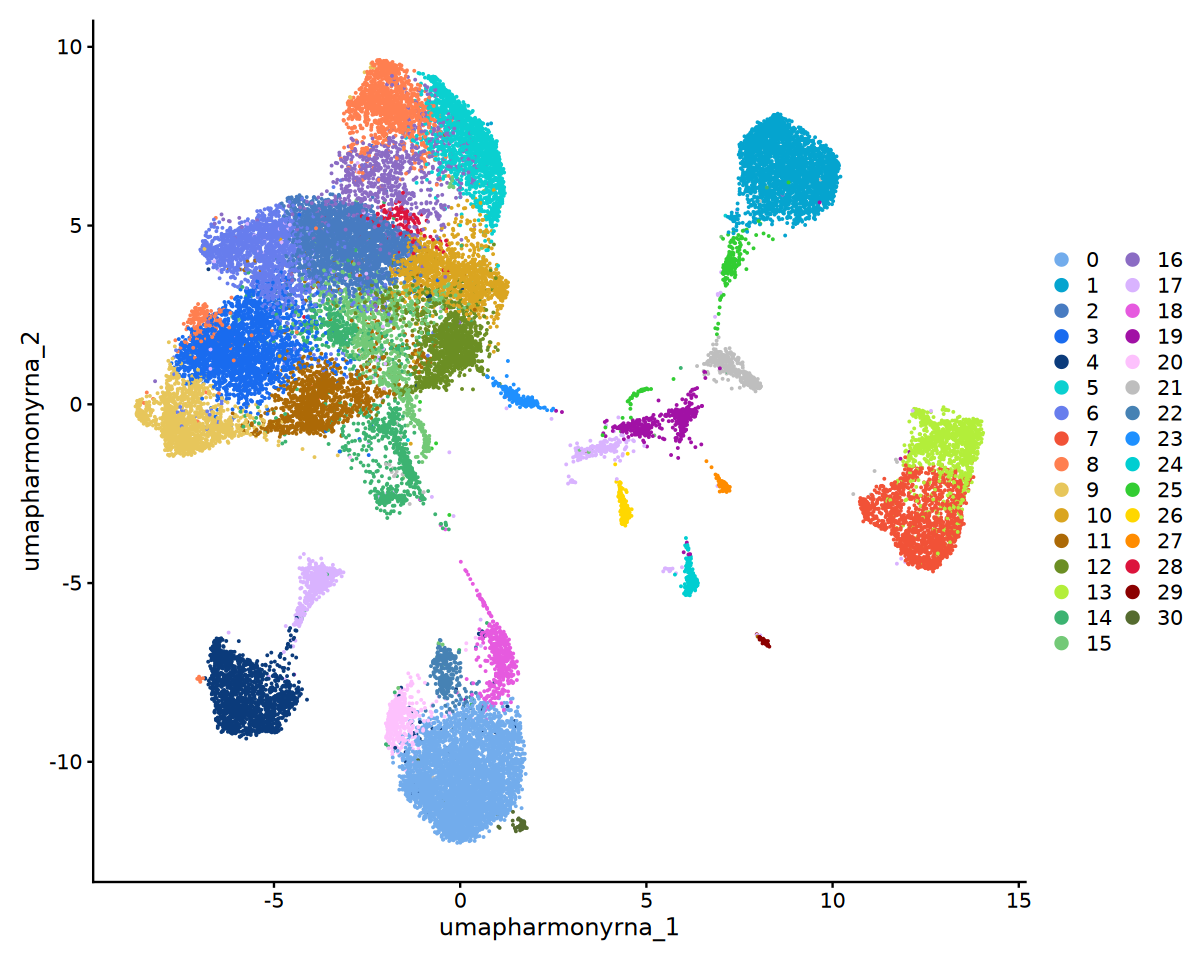

In [31]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj, reduction = "umap.harmony.rna", cols = colors)

In [ ]:
setwd("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/rds_objs/")

In [32]:
saveRDS(sobj,"250322_lib_donor_batch_SCT_3libs.RDS")